### RNN-LSTM 기반의 영어 감정 분석기
##### FRIENDS 시트콤 데이터

In [1246]:
import tensorflow as tf
import keras
import pandas as pd
from pandas import DataFrame as df
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 1. 데이터 로드

In [1247]:
## 데이터셋 로드

# Training Set
train_data2 = pd.read_csv('./friends_train_아스키제거_감정코드.csv')

# Dev Set
dev_data2 = pd.read_csv('./friends_dev_아스키제거_감정코드.csv')

# Test Set
test_data2 = pd.read_csv('./friends_test_아스키제거_감정코드.csv')

print("Training_Set : ", len(train_data2))
print("Dev_Set : ", len(dev_data2))
print("Test_Set : ", len(test_data2))

Training_Set :  10561
Dev_Set :  1178
Test_Set :  2764


### 2. 데이터 전처리(Train, Dev, Test)
##### 중복 확인/제거

In [1248]:
train_data2['utterance'].nunique(), train_data2['emotion'].nunique() # 중복 확인
train_data2.drop_duplicates(subset=['utterance'], inplace=True, ignore_index=True) # 중복 제거
train_data2 = train_data2.dropna(how = 'any')

dev_data2['utterance'].nunique(), dev_data2['emotion'].nunique() # 중복 확인
dev_data2.drop_duplicates(subset=['utterance'], inplace=True, ignore_index=True) # 중복 제거
dev_data2 = dev_data2.dropna(how = 'any')

test_data2['utterance'].nunique(), test_data2['emotion'].nunique() # 중복 확인
test_data2.drop_duplicates(subset=['utterance'], inplace=True, ignore_index=True) # 중복 제거
test_data2 = test_data2.dropna(how = 'any')

print("Training_Set : ", len(train_data2))
print("Dev_Set : ", len(dev_data2))
print("Test_Set : ", len(test_data2))

Training_Set :  9274
Dev_Set :  1090
Test_Set :  2502


### 3. 데이터 정제(Train, Dev, Test)
##### 소문자로 통일, 축약문 교정, 영어/공백/?/! 를 제외한 문자 제거
##### 정제 후, Null 값 제거
##### 데이터 1차 저장(train_data_set.csv, dev_data_set.csv, test_data_set.csv)

In [1249]:
from soynlp.normalizer import * # 반복문자 교정

# 축약문 교정
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", "y'know": "you know", "gonna": "going to", "wanna": "want to", "gotta": "got to"}

#print(contractions)

In [1250]:
### 전처리 및 전처리 결과 저장
# Train Data
temp = pd.DataFrame(columns=['utterance'])
temp['utterance'] = train_data2['utterance'].copy()

for i in range(len(temp)):
    temp['utterance'][i] = temp['utterance'][i].lower() # 소문자 통일
    #train_data2['utterance'][i] = re.sub('[o]{3,}', 'oo', train_data2['utterance'][i]) #반복(3개 이상)이면 2개로 변경 ex)Nooo -> noo
    #train_data2['utterance'][i] = re.sub('[h]{3,}', 'hh', train_data2['utterance'][i])
    #train_data2['utterance'][i] = re.sub('[m]{3,}', 'mm', train_data2['utterance'][i])
    #train_data2['utterance'][i] = re.sub('"', '', train_data2['utterance'][i]) #쌍따옴표 제거
    #train_data2['utterance'][i] = re.sub(r"'s\b", " ", train_data2['utterance'][i]) #소유격 제거
    #temp['utterance'][i] = repeat_normalize(temp['utterance'][i], num_repeats=3) # 반복(4개 이상)이면 3개로 변경
    temp['utterance'][i] = ' '.join([contractions[t] if t in contractions else t for t in temp['utterance'][i].split(" ")]) # 축약문 교정
    temp['utterance'][i] = re.sub("[^a-zA-Z ? !]", " ", temp['utterance'][i]) # 을 제외한 문자 제거
    temp = temp.dropna(how = 'any') # 전처리 후 Null값 제거
train_data2['utterance'] = temp['utterance'].copy()
train_data2 = train_data2.dropna(how = 'any') # 전처리 후 Null값 제거
train_data2.to_csv("train_data_set.csv", mode='w', index=False)

In [1251]:
# Dev Data
temp = pd.DataFrame(columns=['utterance'])
temp['utterance'] = dev_data2['utterance'].copy()

for i in range(len(dev_data2)):   
    temp['utterance'][i] = temp['utterance'][i].lower() # 소문자 통일
    #temp['utterance'][i] = repeat_normalize(temp['utterance'][i], num_repeats=3) # 반복(4개 이상)이면 3개로 변경
    temp['utterance'][i] = ' '.join([contractions[t] if t in contractions else t for t in temp['utterance'][i].split(" ")]) # 축약문 교정
    temp['utterance'][i] = re.sub("[^a-zA-Z ? !]", " ", temp['utterance'][i]) # 을 제외한 문자 제거
    temp = temp.dropna(how = 'any') # 전처리 후 Null값 제거
dev_data2['utterance'] = temp['utterance'].copy()
dev_data2 = dev_data2.dropna(how = 'any') # 전처리 후 Null값 제거
dev_data2.to_csv("dev_data_set.csv", mode='w', index=False)

In [1252]:
# Test Data
temp = pd.DataFrame(columns=['utterance'])
temp['utterance'] = test_data2['utterance'].copy()

for i in range(len(test_data2)):
    temp['utterance'][i] = temp['utterance'][i].lower() # 소문자 통일
    #temp['utterance'][i] = repeat_normalize(temp['utterance'][i], num_repeats=3) # 반복(4개 이상)이면 3개로 변경
    temp['utterance'][i] = ' '.join([contractions[t] if t in contractions else t for t in temp['utterance'][i].split(" ")]) # 축약문 교정
    temp['utterance'][i] = re.sub("[^a-zA-Z ? !]", " ", temp['utterance'][i]) # 을 제외한 문자 제거
    temp = temp.dropna(how = 'any') # 전처리 후 Null값 제거
test_data2['utterance'] = temp['utterance'].copy()
test_data2 = test_data2.dropna(how = 'any') # 전처리 후 Null값 제거
test_data2.to_csv("test_data_set.csv", mode='w', index=False)

### 3. 토큰화
##### 데이터 로드, 토큰화, 불용어 제거, 표제어/어간(Lemmatization, Stemming) 추출

In [1967]:
### 전처리 결과 불러오기

train_data2 = pd.read_csv('./train_data_set.csv')
dev_data2 = pd.read_csv('./dev_data_set.csv')
test_data2 = pd.read_csv('./test_data_set.csv')

In [1968]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from tensorflow.keras.preprocessing.text import text_to_word_sequence # 토큰화
tokenizer = Tokenizer()

from nltk.tokenize import TreebankWordTokenizer
tbwt = TreebankWordTokenizer()

from nltk.corpus import stopwords # StopWord(불용어)
stopwords.words('english')

## Lemma
# Lemmatization
from nltk.stem import WordNetLemmatizer
n = WordNetLemmatizer()

## Stem
# Stemming_Porter
from nltk.stem import PorterStemmer
p = PorterStemmer()

# Stemming_Lancaster
from nltk.stem import LancasterStemmer
l=LancasterStemmer()

# Stemming_SnowballStemmer
from nltk.stem import SnowballStemmer
s = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\server\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\server\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [1969]:
new_stopwords = ['me','my','myself','you','your','yours','yourself','yourselves',
                 'he','him','his','himself','she','her','hers','herself','we','our','ours','ourselves', 
                 'they','them','their','theirs','themselves','it','its','itself','this','that','these','those', 
                 'am','is','are','was','were','be','been','being', 
                 'will','should','would','could' 'may','might','have','has','had','having','do','does','did','doing',
                 'an','the','and','or','against','between',
                 'into','through','during','before','after','above','below','under','again','further','then','once','here','there',
                 'now','both','each','few','other','own','same','ll','re','ve','ma','mr','ms','mrs',
                 'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
#'of','at','by','for','with','about','to','from','up','down','in','out','on','off','over','as','until','just','all',
#print(stopwords.words('english'))

In [1970]:
## Train 데이터

X_train2 = []

for sentence in train_data2['utterance']:
    temp_X2 = []
    
    # 토큰화
    #temp_X2 = text_to_word_sequence(sentence)
    temp_X2 = tbwt.tokenize(sentence)
    
    # Stopwords(불용어) 제거
    temp_X2 = [word for word in temp_X2 if not word in new_stopwords]
    #temp_X2 = [word for word in temp_X2 if not word in stopwords.words('english')]
    
    # Lemmatization
    temp_X2 = [n.lemmatize(word, 'v') for word in temp_X2]
    
    # Stemming_Porter
    #temp_X2 = [p.stem(word) for word in temp_X2]
    
    # Stemming_Lancaster
    #temp_X2 = [l.stem(word) for word in temp_X2]
    
    # Stemming_SnowballStemmer
    #temp_X2 = [s.stem(word) for word in temp_X2]
    
    X_train2.append(temp_X2)

In [1971]:
## Dev 데이터

X_dev2 = []
    
for sentence in dev_data2['utterance']:
    temp_X2 = []
    
    # 토큰화
    #temp_X2 = text_to_word_sequence(sentence)
    temp_X2 = tbwt.tokenize(sentence)
    
    # Stopwords(불용어) 제거
    temp_X2 = [word for word in temp_X2 if not word in new_stopwords]
    #temp_X2 = [word for word in temp_X2 if not word in stopwords.words('english')]
    
    # Lemmatization
    temp_X2 = [n.lemmatize(word, 'v') for word in temp_X2]
    
    # Stemming_Porter
    #temp_X2 = [p.stem(word) for word in temp_X2]
    
    # Stemming_Lancaster
    #temp_X2 = [l.stem(word) for word in temp_X2]
    
    # Stemming_SnowballStemmer
    #temp_X2 = [s.stem(word) for word in temp_X2]
    
    X_dev2.append(temp_X2)

In [1972]:
## Test 데이터

X_test2 = []

for sentence in test_data2['utterance']:
    temp_X2 = []
    
    # 토큰화
    #temp_X2 = text_to_word_sequence(sentence)
    temp_X2 = tbwt.tokenize(sentence)
    
    # Stopwords(불용어) 제거
    temp_X2 = [word for word in temp_X2 if not word in new_stopwords]
    #temp_X2 = [word for word in temp_X2 if not word in stopwords.words('english')]
    
    # Lemmatization
    temp_X2 = [n.lemmatize(word, 'v') for word in temp_X2]    
    
    # Stemming_Porter
    #temp_X2 = [p.stem(word) for word in temp_X2]
    
    # Stemming_Lancaster
    #temp_X = [l.stem(word) for word in temp_X2]
    
    # Stemming_SnowballStemmer
    #temp_X2 = [s.stem(word) for word in temp_X2]
        
    X_test2.append(temp_X2)
    

### 4. 정수 인코딩

In [1977]:
# 빈도순 단어 집합 생성 -> 높은 정수값은 빈도가 낮은 것
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train2)

#print(tokenizer.word_index)

In [1978]:
total_cnt = len(tokenizer.word_index)
#print(total_cnt)

4458


In [1979]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('[총 단어 수] 단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

[총 단어 수] 단어 집합(vocabulary)의 크기 : 4458
등장 빈도가 2번 이하인 희귀 단어의 수: 2864
단어 집합에서 희귀 단어의 비율: 64.2440556303275
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.835530570618378


In [1980]:
# 전체 단어 개수 중 빈도수 2번 이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2

vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1596


In [1981]:
# 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환하겠습니다. 다시 말해 정수 1번으로 할당
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train2)

X_train2 = tokenizer.texts_to_sequences(X_train2)
X_dev2 = tokenizer.texts_to_sequences(X_dev2)
X_test2 = tokenizer.texts_to_sequences(X_test2)

In [1982]:
y_train2 = np.array(train_data2['emotion_code'])
y_dev2 = np.array(dev_data2['emotion_code'])
y_test2 = np.array(test_data2['emotion_code'])

In [1983]:
X_train2 = np.array(X_train2)
X_dev2 = np.array(X_dev2)
X_test2 = np.array(X_test2)

### 5. 빈 샘플 제거

In [1984]:
drop_train2 = [index for index, sentence in enumerate(X_train2) if len(sentence) < 1]

In [1985]:
#print(drop_train2)
# 빈 샘플들을 제거
X_train2 = np.delete(X_train2, drop_train2, axis=0)
y_train2 = np.delete(y_train2, drop_train2, axis=0)

### 6. 패딩

대사 최대 길이 : 47
대사 평균 길이 : 6.53549365991113


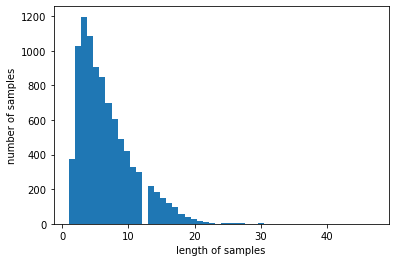

In [1986]:
print('대사 최대 길이 :',max(len(l) for l in X_train2))
print('대사 평균 길이 :',sum(map(len, X_train2))/len(X_train2))
plt.hist([len(s) for s in X_train2], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [1987]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [1988]:
max_len = 14
below_threshold_len(max_len, X_train2)

전체 샘플 중 길이가 14 이하인 샘플의 비율: 94.12593475669232


In [1989]:
# 모든 샘플 길이 통일
X_train2 = pad_sequences(X_train2, maxlen=max_len)
X_dev2 = pad_sequences(X_dev2, maxlen=max_len)
X_test2 = pad_sequences(X_test2, maxlen=max_len)

In [1990]:
# 훈련/검증/테스트용 레이블의 원-핫 인코딩
from keras.utils import to_categorical

y_train2 = to_categorical(y_train2)
y_dev2 = to_categorical(y_dev2)
y_test2 = to_categorical(y_test2)

### 7. LSTM 모델 설정 및 학습/평가

In [1991]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

model2 = Sequential()

model2.add(Embedding(vocab_size, 64, input_length=max_len))
model2.add(Dropout(0.5))
model2.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(8, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('friends_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [1992]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history2 = model2.fit(X_train2, y_train2, batch_size=64, epochs=15, callbacks=[es, mc], validation_data=(X_dev2, y_dev2))

Epoch 1/15
141/145 [============================>.] - ETA: 0s - loss: 1.7085 - acc: 0.4240
Epoch 00001: val_acc improved from -inf to 0.44587, saving model to friends_best_model.h5
145/145 [==============================] - 2s 13ms/step - loss: 1.7043 - acc: 0.4252 - val_loss: 1.5864 - val_acc: 0.4459
Epoch 2/15
142/145 [============================>.] - ETA: 0s - loss: 1.5021 - acc: 0.4922
Epoch 00002: val_acc improved from 0.44587 to 0.46606, saving model to friends_best_model.h5
145/145 [==============================] - 2s 11ms/step - loss: 1.5018 - acc: 0.4924 - val_loss: 1.5238 - val_acc: 0.4661
Epoch 3/15
142/145 [============================>.] - ETA: 0s - loss: 1.4401 - acc: 0.5041
Epoch 00003: val_acc improved from 0.46606 to 0.47339, saving model to friends_best_model.h5
145/145 [==============================] - 2s 11ms/step - loss: 1.4408 - acc: 0.5036 - val_loss: 1.5211 - val_acc: 0.4734
Epoch 4/15
141/145 [============================>.] - ETA: 0s - loss: 1.4023 - acc: 0

In [1993]:
loaded_model2 = load_model('friends_best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model2.evaluate(X_test2, y_test2)[1]))

79/79 [==============================] - 0s 2ms/step - loss: 1.2709 - acc: 0.5608

 테스트 정확도: 0.5608


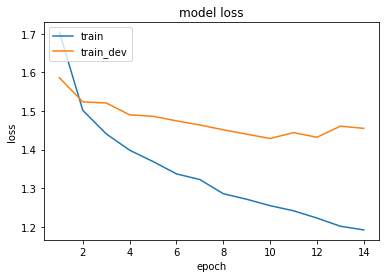

In [1994]:
epochs = range(1, len(history2.history['loss']) + 1)
plt.plot(epochs, history2.history['loss'])
plt.plot(epochs, history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'train_dev'], loc='upper left')
plt.show()

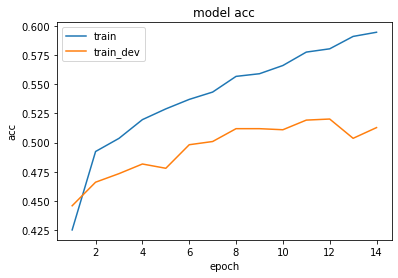

In [1995]:
epochs = range(1, len(history2.history['acc']) + 1)
plt.plot(epochs, history2.history['acc'])
plt.plot(epochs, history2.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'train_dev'], loc='upper left')
plt.show()

In [1996]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pandas import DataFrame as df

predictions2 = model2.predict(X_test2)

y_pred2 = []
for i in range (len(predictions2)):
    val_index = []
    val_index.append(np.argmax(predictions2[i]))
    y_pred2.append(val_index)
    
y_pred2 = np.array(y_pred2)


actual = []
for i in range (len(y_test2)):
    val_index = []
    val_index.append(np.argmax(y_test2[i]))
    actual.append(val_index)

cf2 = confusion_matrix(actual, y_pred2)
print(cf2)

[[   1    0    0   32   29   75    0   18]
 [   1    0    0    5   36   20    1    4]
 [   0    0    0    3   14   11    0    3]
 [   0    0    0  144   57   38    0   19]
 [   0    0    0   41 1013   71    2   28]
 [   1    0    0   66  257  114    8   68]
 [   0    0    0    3   60   10   10    1]
 [   0    0    0   26   68   29    0  115]]


In [1999]:
df_cm2 = df(cf2, index=[i for i in "01234567"], columns= [i for i in "01234567"])
df_cm2

,0,1,2,3,4,5,6,7
0,1,0,0,32,29,75,0,18
1,1,0,0,5,36,20,1,4
2,0,0,0,3,14,11,0,3
3,0,0,0,144,57,38,0,19
4,0,0,0,41,1013,71,2,28
5,1,0,0,66,257,114,8,68
6,0,0,0,3,60,10,10,1
7,0,0,0,26,68,29,0,115


<AxesSubplot:title={'center':'confusion matrix without confusion'}>

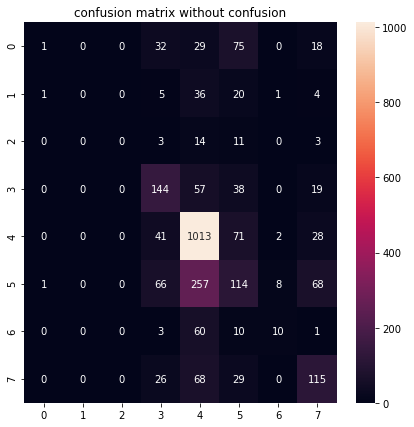

In [2000]:
plt.figure(figsize = (7,7))
plt.title('confusion matrix without confusion')
sns.heatmap(df_cm2, annot=True, fmt='d')

### Private Data 평가 실행

In [2002]:
def sentiment_predict(new_sentence):

    # 전처리
    new_sentence = new_sentence.lower() # 소문자로 통일
    #new_sentence = repeat_normalize(new_sentence, num_repeats=3) # 반복(4개 이상)이면 3개로 변경
    new_sentence = ' '.join([contractions[t] if t in contractions else t for t in new_sentence.split(" ")]) # 축약문 교정
    new_sentence = re.sub("[^a-zA-Z ? !]", " ", new_sentence) # 영어, 공백, ?, ! 을 제외한 문자 제거
    
    #토큰화
    #new_sentence = text_to_word_sequence(new_sentence)  
    new_sentence = tbwt.tokenize(new_sentence)
    
    #Stopword(불용어) 제거
    #new_sentence = [word for word in new_sentence if not word in stopwords.words('english')]
    new_sentence = [word for word in new_sentence if not word in new_stopwords]
    
    #Lemmatization
    new_sentence = [n.lemmatize(word, 'v') for word in new_sentence] 
    
    # Stemming_Porter
    #new_sentence = [p.stem(word) for word in new_sentence]
    
    # Stemming_Lancaster
    #new_sentence = [l.stem(word) for word in new_sentence]
    
    # Stemming_SnowballStemmer
    #new_sentence = [s.stem(word) for word in new_sentence]        
    
    #정수 인코딩
    encoded = tokenizer.texts_to_sequences([new_sentence])
    
    #패딩
    pad_new = pad_sequences(encoded, maxlen = max_len)
    
    score = loaded_model2.predict(pad_new)

    #val = np.max(score)
    val_index = np.argmax(score)

    if(val_index==0):
        return "anger"
    elif(val_index==1):
        return "disgust"
    elif(val_index==2):
        return "fear"
    elif(val_index==3):
        return "joy"
    elif(val_index==4):
        return "neutral"
    elif(val_index==5):
        return "non-neutral"
    elif(val_index==6):
        return "sadness"
    elif(val_index==7):
        return "surprise"

In [1998]:
eval_data = pd.read_csv('./en_data.csv', engine='python', encoding='utf-8')
eval_data['Predicted'] = 0

for i in range(len(eval_data)):
    Predicted = sentiment_predict(eval_data['utterance'][i])
    eval_data['Predicted'][i] = Predicted
    
eval_data.drop(['i_dialog'], axis='columns', inplace=True)
eval_data.drop(['i_utterance'], axis='columns', inplace=True)
eval_data.drop(['speaker'], axis='columns', inplace=True)
eval_data.drop(['utterance'], axis='columns', inplace=True)

eval_data.to_csv("result_2019512014_이동환.csv", index=False)

<ipython-input-1998-cfee1748ee8f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_data['Predicted'][i] = Predicted
